In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, logging, pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from flarestack.data.icecube import ps_v002_p01
from flarestack.shared import plot_output_dir, flux_to_k, k_to_flux, storage_dir
from flarestack.analyses.ccsn.necker_2019.ccsn_helpers import sn_cats, updated_sn_catalogue_name, raw_output_dir
from flarestack.analyses.ccsn import get_sn_color
from flarestack.utils.custom_dataset import custom_dataset
from flarestack.utils.prepare_catalogue import custom_sources, cat_dtype
from flarestack.utils.catalogue_loader import load_catalogue
from flarestack.core.minimisation import MinimisationHandler
from flarestack.core.experimental_injector import MultiSeasonsInjector, ExperimentalInjector

logging.getLogger().setLevel("DEBUG")
logging.debug('logging level is DEBUG')
logging.getLogger('matplotlib').setLevel('INFO')
logger = logging.getLogger('main')
logger.debug('hi')

DEBUG:root:logging level is DEBUG
DEBUG:main:hi


### set up some parameters ###

In [3]:
dang = 5
smoothing = 'flarestack'
seasons = ['IC86_234']
cluster = True
ntrials = 100
gammas = [2, 2.5, 3]
# cats = ['Ibc', 'IIn', 'IIP']
# ref_time_mjd = np.nan
injection_bandwidth = 2
# sl_injection_bandwidth = 1
# mh_name = 'large_catalogue'
# injector = 'low_memory_injector'

# minimizer and injectors names
mh_inj_names = [
    ('large_catalogue', 'low_memory_injector'),
    ('fixed_weights', 'mc_injector')
]

scales = [1]

In [4]:
injection_energy = {
    "energy_pdf_name": "power_law"
}

injection_time = {
    'time_pdf_name': 'steady'
}

llh_energy = {
    "energy_pdf_name": "power_law"
}

llh_time = {
    'time_pdf_name': 'steady'
}

seasons_str = ''
if isinstance(seasons, list):
    for s in seasons:
        seasons_str += '_' + s

if seasons == '':
    seasons_str = '_all'

raw = f"analyses/internal_checks/compare_injections_bandwidth{injection_bandwidth}{seasons_str}/{smoothing}-smoothing_dang{dang}"

if not os.path.exists(plot_output_dir(raw)):
    os.makedirs(plot_output_dir(raw))

data = ps_v002_p01
if seasons:
    data = data.get_seasons(*seasons)

### set up the sources ###

In [5]:
hemispheres = ['northern', 'southern', 'both']
max_nsources = 20
Nsources_list = [1, 5, 15, 20]

# sin(declinations) for northern and southern sources
sindecs = {
    'northern': list(np.linspace(0,  0.75, max_nsources, endpoint=True)),
    'southern': list(np.linspace(-0.5, 0, max_nsources, endpoint=False))
}

# right ascensions
ras = {
    'northern': list(np.linspace(0, 2*np.pi, max_nsources, endpoint=False)),
    'southern': list(np.linspace(0, 2*np.pi, max_nsources, endpoint=False))
}

# create an entry with northern and southern sources mixed
for d in [sindecs, ras]:
    d['both'] = list()
    for i in range(int(max_nsources/2)):
        d['both'].append(d['northern'][i])
        d['both'].append(d['southern'][i])

In [6]:
def make_sources(hemisphere, number_of_sources):
    """makes flarestack sources array"""
    sds, rs = np.array(sindecs[hemisphere])[:number_of_sources], np.array(ras[hemisphere])[:number_of_sources]
    names = [f'sindec={sd:.2f}' for sd in sds]
    weight = distance = [1.] * len(sds)
    sources = np.empty(shape=len(sds), dtype=cat_dtype)
    for i, (n, r, sd, w, dist) in enumerate(zip(names, rs, sds, weight, distance)):
        new_source = custom_sources(name=n, ra=np.rad2deg(r), dec=np.rad2deg(np.arcsin(sd)), weight=w, distance=dist)
        sources[i] = new_source
    return sources

## calculate expected number of neutrinos ##

In [7]:
res_dict = dict()
logging.getLogger().setLevel('DEBUG')

for hsphere in ['northern', 'southern', 'both']:
    hsphere_res = dict()

    for N in Nsources_list:
        logger.info(f'{N} sources')
        Nsources_res = dict()

        cat_path = os.path.join(storage_dir, raw, 'catalogues', f'{N}sources.npy')
        
        if not os.path.isfile(cat_path):
            logger.info(f'making sources at {cat_path}')
            sources = make_sources(hsphere, N)
            
            d = os.path.dirname(cat_path)
            if not os.path.isdir(d):
                os.makedirs(d)
            
            np.save(cat_path, sources)
            
        else:
            sources = np.load(cat_path)

        for mh_name, injector in mh_inj_names:
            logger.info(f'{mh_name} {injector}')
            mh_inj_res = dict()

            for gamma in gammas:
                logger.debug(f'gamma={gamma}')

                injection_energy['gamma'] = gamma

                inj_dict = {
                    'injector_name': injector,
                    'injection_energy_pdf': injection_energy,
                    'injection_sig_time_pdf': injection_time,
                    'injection_declination_bandwidth': injection_bandwidth
                }

                llh_dict = {
                    "llh_name": "standard" if not mh_name == 'large_catalogue' else 'standard_matrix',
                    "llh_energy_pdf": llh_energy,
                    "llh_sig_time_pdf": llh_time,
                    "llh_bkg_time_pdf": {"time_pdf_name": "steady"},
                    "gamma_precision": smoothing,
                    "smoothing_order": smoothing,
                    'spatial_box_width': dang
                }

                full_name = f'{raw}/{hsphere}/{N}/{mh_name}-{injector}/{gamma}'
                dataset = custom_dataset(data, sources, llh_dict["llh_sig_time_pdf"])

                mh_dict = {
                    "name": full_name,
                    "mh_name": mh_name,
                    "dataset": dataset,
                    "catalogue": cat_path,
                    "inj_dict": inj_dict,
                    "llh_dict": llh_dict,
                }

                mh = MinimisationHandler.create(mh_dict)
                injectors = {sname: mh.get_injector(sname) for sname in mh.seasons.keys()}

                g = dict()
                for scale in scales:
                    logger.info(f'scale={scale}')

                    nexp = 0
                    for source in mh.sources:
                        for inj in injectors.values():
                            nexp += inj.get_expectation(source, scale)

                    g[scale] = {'nexp': nexp}

                mh_inj_res[gamma] = g

            Nsources_res[f'{mh_name}/{injector}'] = mh_inj_res
        
        hsphere_res[N] = Nsources_res
        
    res_dict[hsphere] = hsphere_res

INFO:main:1 sources
INFO:main:making sources at /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/storage/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/catalogues/1sources.npy
INFO:main:large_catalogue low_memory_injector
DEBUG:main:gamma=2
INFO:flarestack.core.minimisation:Using 'standard_matrix' LLH class
INFO:flarestack.core.injector:Initialising Injector for IC86_234
DEBUG:flarestack.utils.make_SoB_splines:Loading from /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/input/bkg_splines/ps_tracks_v002_p01/IC86_234.pkl
INFO:flarestack.shared:Breaking catalogue into 1 chunks of 100
DEBUG:flarestack.core.injector:loading bandmask from /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/storage/cache/catalogue_cache/4052159332/ps_tracks_v002_p01/IC86_234.npz
INFO:main:scale=1
DEBUG:main:gamma=2.5
INFO:flarestack.core.minimisation:Using 'standard_matrix' LLH class
INFO:flarestack.core.injector:I

In [8]:
filename = storage_dir + raw + '.pkl'

In [9]:
d = os.path.dirname(filename)
if not os.path.isdir(d):
    os.makedirs(d)

with open(filename, 'wb') as f:
    pickle.dump(res_dict, f)

In [10]:
with open(filename, 'rb') as f:
    res_dict = pickle.load(f)

In [11]:
colors = {'IC40':'blue', 'IC59':'red', 'IC79':'green', 'IC86_1':'purple', 'IC86_234':'k'}
markers = ['o', 'x', '+']

## plot ratio ##

INFO:main:saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/nexp_ratios/northern_2.00.pdf


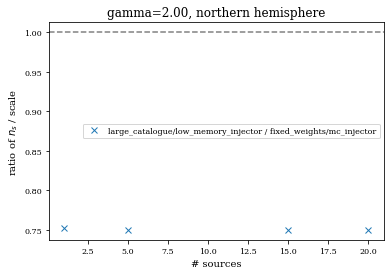

INFO:main:saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/nexp_ratios/northern_2.50.pdf


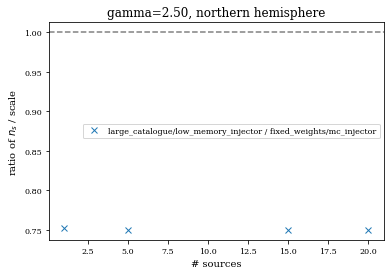

INFO:main:saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/nexp_ratios/northern_3.00.pdf


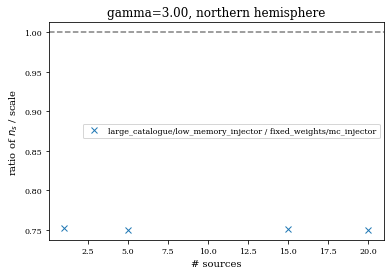

INFO:main:saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/nexp_ratios/southern_2.00.pdf


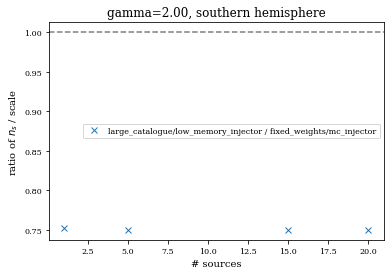

INFO:main:saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/nexp_ratios/southern_2.50.pdf


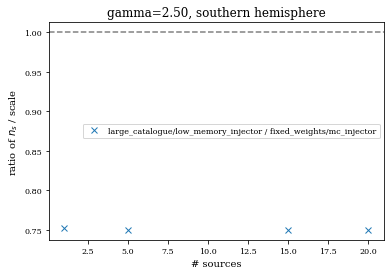

INFO:main:saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/nexp_ratios/southern_3.00.pdf


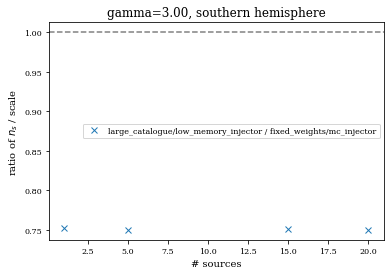

INFO:main:saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/nexp_ratios/both_2.00.pdf


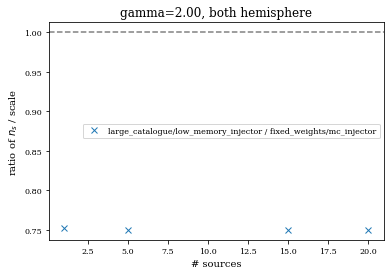

INFO:main:saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/nexp_ratios/both_2.50.pdf


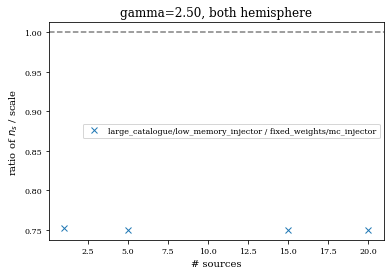

INFO:main:saving under /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/internal_checks/compare_injections_bandwidth2_IC86_234/flarestack-smoothing_dang5/nexp_ratios/both_3.00.pdf


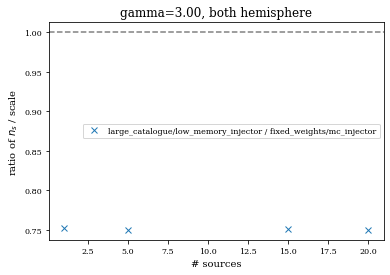

In [12]:
scale = 1.

for hsphere, hsphere_res in res_dict.items():
    
    for gamma in gammas:
        
        ddata = dict()
        ddata['N'] = list() 
        
        for N, Nsources_res in hsphere_res.items():
            
            ddata['N'].append(N)
            
            for n, mh_inj_res in Nsources_res.items():
                
                if n not in ddata:
                    ddata[n] = list()
                    
                ddata[n].append(mh_inj_res[gamma][scale]['nexp'] / k_to_flux(scale))
                
        fig, ax = plt.subplots()
        keys = list(ddata.keys())
        for i, n in enumerate(keys):
            if n == 'N':
                continue
            for scnd_n in keys[i+1:]:
                y = np.array(ddata[n]) / np.array(ddata[scnd_n])
                ax.plot(ddata['N'], y, label=f'{n} / {scnd_n}', marker=markers[i], ls='')
                
        ax.axhline(1, ls='--', color='k', alpha=0.5)
            
        ax.set_ylabel('ratio of $n_{s}$ / scale')
        ax.set_xlabel('# sources')
        ax.legend()
        ax.set_title(f'gamma={gamma:.2f}, {hsphere} hemisphere')
        
        pdf_filename = os.path.join(plot_output_dir(raw), 'nexp_ratios', f'{hsphere}_{gamma:.2f}.pdf')
        if not os.path.isdir(os.path.dirname(pdf_filename)):
            os.makedirs(os.path.dirname(pdf_filename))
        logger.info(f'saving under {pdf_filename}')
        fig.savefig(pdf_filename)
        plt.show()
        plt.close()

## plotting flux to ns conversion ##

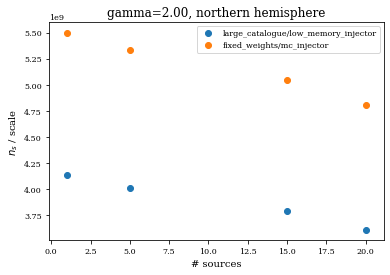

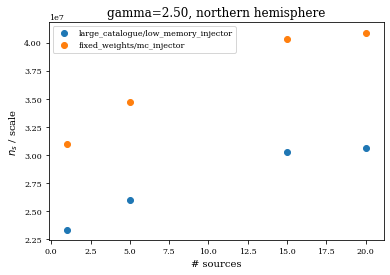

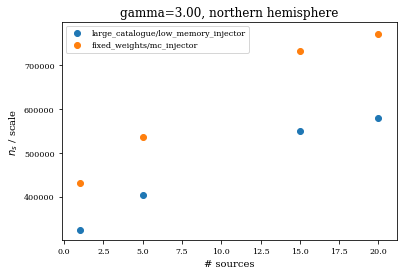

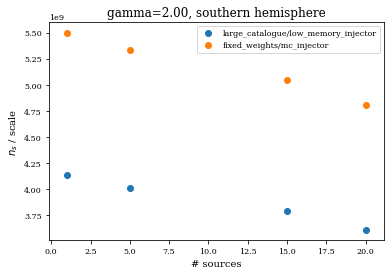

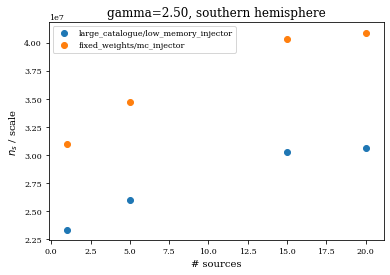

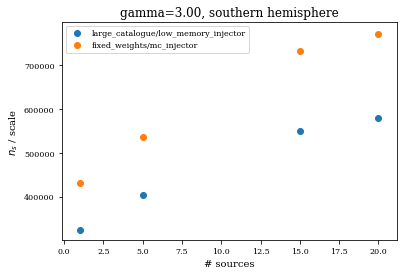

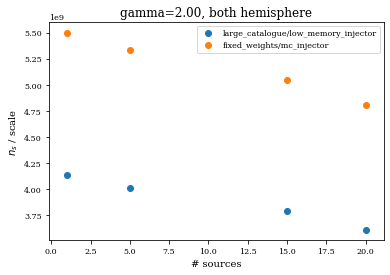

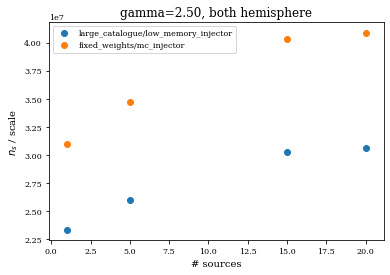

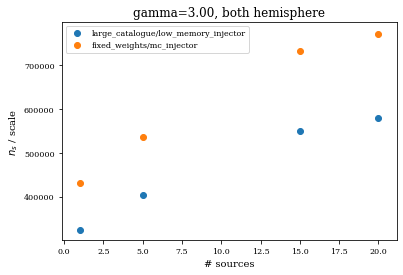

In [13]:
scale = 1.

for hsphere, hsphere_res in res_dict.items():
    
    for gamma in gammas:
        
        ddata = dict()
        ddata['N'] = list() 
        
        for N, Nsources_res in hsphere_res.items():
            
            ddata['N'].append(N)
            
            for n, mh_inj_res in Nsources_res.items():
                
                if n not in ddata:
                    ddata[n] = list()
                    
                ddata[n].append(mh_inj_res[gamma][scale]['nexp'] / k_to_flux(scale))
                
        fig, ax = plt.subplots()
        for n in ddata.keys():
            if n == 'N':
                continue
            ax.scatter(ddata['N'], ddata[n], label=n, marker='o')
            
        ax.set_ylabel('$n_{s}$ / scale')
        ax.set_xlabel('# sources')
        ax.legend()
        ax.set_title(f'gamma={gamma:.2f}, {hsphere} hemisphere')
        
        plt.show()
        plt.close()